In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

In [3]:
#Set the feeder
_feeder='epri_j1'

## Voltage Profiles

In [4]:
#Load the voltage profiles
volt_prof_before=pd.read_csv('../inputs/opendss/{feeder}/voltage_profile.csv'.format(feeder=_feeder))
volt_prof_after=pd.read_csv('../outputs/from_opendss/to_opendss/{feeder}/voltage_profile.csv'.format(feeder=_feeder))

In [5]:
#Put all bus names in lower case
volt_prof_before['Bus']=volt_prof_before['Bus'].apply(lambda x:x.lower())
volt_prof_after['Bus'] =volt_prof_after['Bus'].apply(lambda x:x.lower())

In [6]:
#Set the index to be the bus names
volt_prof_before.set_index('Bus', inplace=True)
volt_prof_after.set_index('Bus', inplace=True)

In [7]:
#Compute the metric of interest
#
#Here, we compute the sum of absolute 
#differences on all phases at each node
#
_delta=(np.abs(volt_prof_before[' pu1']-volt_prof_after[' pu1'])+
        np.abs(volt_prof_before[' pu2']-volt_prof_after[' pu2'])+
        np.abs(volt_prof_before[' pu3']-volt_prof_after[' pu3']))

In [8]:
#Switch to dict
_delta=_delta.to_dict()

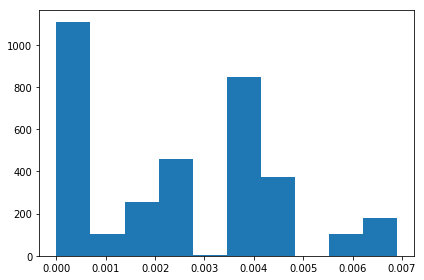

In [9]:
#Plot the distribution
plt.hist(np.nan_to_num(_delta.values()), bins=10)
plt.tight_layout()

## Network

To build the graph, we use the network module of ditto. This implies that we have to run the reader again unless the ditto model or the graph itself was saved somewhere.

In [10]:
#Build the DiTTo model first...
from ditto.store import Store
from ditto.readers.opendss.read import reader

m=Store()

inputs={'master_file':'../inputs/opendss/{feeder}/master.dss'.format(feeder=_feeder),
        'buscoordinates_file': '../inputs/opendss/{feeder}/buscoords.dss'.format(feeder=_feeder)}

#Instanciate the reader
opendss_reader=reader(**inputs)

#Parse...
opendss_reader.parse(m)

/Users/ngensoll/anaconda2/lib/python2.7/site-packages/fuzzywuzzy-0.15.1-py2.7.egg/fuzzywuzzy/fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning


'build_opendssdirect' ((<ditto.readers.opendss.read.reader instance at 0x1516a8db00>, '../inputs/opendss/epri_j1/master.dss'), {}) 0.67 sec
Build OpenDSSdirect= 0.670960187912
'parse_power_source' ((<ditto.readers.opendss.read.reader instance at 0x1516a8db00>, <ditto.store.Store(elements=0, models=1) object at 0x140cef4ad0>), {}) 0.01 sec


/Users/ngensoll/GitRepos/OpenDSSDirect.py/opendssdirect/utils.py:98: UserWarning: Pandas cannot be installed. Please see documentation for how to install extra dependencies.
  "Pandas cannot be installed. Please see documentation for how to install extra dependencies."


'parse_nodes' ((<ditto.readers.opendss.read.reader instance at 0x1516a8db00>, <ditto.store.Store(elements=0, models=6881) object at 0x140cef4ad0>), {}) 6.59 sec
'parse_lines' ((<ditto.readers.opendss.read.reader instance at 0x1516a8db00>, <ditto.store.Store(elements=0, models=15549) object at 0x140cef4ad0>), {}) 90.90 sec
'parse_transformers' ((<ditto.readers.opendss.read.reader instance at 0x1516a8db00>, <ditto.store.Store(elements=0, models=19709) object at 0x140cef4ad0>), {}) 14.33 sec
'parse_loads' ((<ditto.readers.opendss.read.reader instance at 0x1516a8db00>, <ditto.store.Store(elements=0, models=22487) object at 0x140cef4ad0>), {}) 4.88 sec
[u'7.2', u'7.2']
[u'7.2', u'7.2']
[u'7.2', u'7.2']
[u'7.2', u'7.2']
[u'7.2', u'7.2']
[u'7.2', u'7.2']


2017-11-10 10:50:52,061 - reader - WARNING - Duplicate object Regulator subxfmr


[u'7.2', u'7.2']
[u'7.2', u'7.2']
[u'7.2', u'7.2']
[u'7.2', u'7.2']
[u'7.2', u'7.2']
[u'7.2', u'7.2']
[u'68.8', u'13.09']
[u'68.8', u'13.09']
[u'7.2', u'7.2']
[u'7.2', u'7.2']
[u'7.2', u'7.2']
[u'7.2', u'7.2']
'parse_regulators' ((<ditto.readers.opendss.read.reader instance at 0x1516a8db00>, <ditto.store.Store(elements=0, models=22536) object at 0x140cef4ad0>), {}) 1.42 sec


2017-11-10 10:50:52,283 - reader - WARNING - Duplicate object Capacitor b18944


'parse_capacitors' ((<ditto.readers.opendss.read.reader instance at 0x1516a8db00>, <ditto.store.Store(elements=0, models=22556) object at 0x140cef4ad0>), {}) 0.03 sec


1

In [11]:
#Now, build the graph...
from ditto.network.network import Network
G=Network()
G.build(m)

In [12]:
#Load the layout
pos={}
with open('../inputs/opendss/{feeder}/buscoords.dss'.format(feeder=_feeder),'r') as f:
    lines=f.readlines()
    for line in lines:
        bus,X,Y=line.split(',')
        if bus!='S':
            pos[bus.strip().lower()]=(float(X),float(Y))

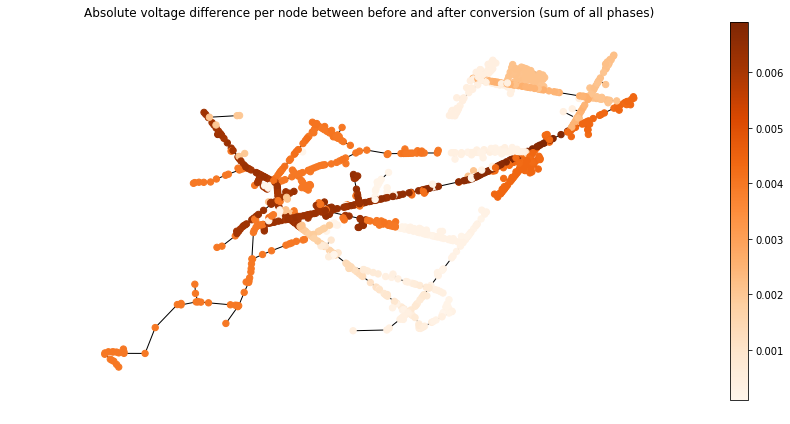

In [14]:
from palettable.colorbrewer.sequential import Oranges_9

fig=plt.figure(figsize=(12,6))

#It might be the case that the network created by DiTTo has more 
#nodes than what we have in the voltage profile. As a quick 
_sub=G.graph.subgraph(volt_prof_after.index)
_sub=_sub.subgraph(pos.keys())
_diff=[_delta[n] for n in _sub.nodes()]
_n=nx.draw_networkx_nodes(_sub, pos, cmap=Oranges_9.mpl_colormap, 
                       node_color=_diff, node_size=40)
nx.draw_networkx_edges(_sub, pos)
#nx.draw_networkx_labels(_sub, pos)
plt.colorbar(_n)
plt.axis('off')
plt.title('Absolute voltage difference per node between before and after conversion (sum of all phases)')
plt.tight_layout()
plt.savefig('./voltage_difference_{feeder}.pdf'.format(feeder=_feeder), dpi=300)